# Neptune Tisserand Parameter plot for TNOs, Centaurs, and Comets

Plot the Neptune Tisserand parameter T<sub>N</sub> versus semi-major axis (a) for TNOS and comets.

Data from the Minor Planet Center and orbit elements from JPL Horizons retrieved using `astroquery`.

TNOs and Centaurs are defined here as all objects with a>20au, also get all comets in this range of a

In [9]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astropy and astroquery 

from astropy.time import Time

from astroquery.mpc import MPC
from astroquery.jplhorizons import Horizons

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

#### Figure Filename

`figName` sets the figure filename of the form `Fig<chapterNum>_<figNum>`, the figure number may also 
include a lowercase  letter for a subfigure (e.g., Fig1_2a).  

#### Aspect Ratio

`aspect` sets the aspect ratio, width/height.  The default aspect ratio is 4:3, 1:1 for square plots, 
and 5:2 (2.5:1) for spectra, and equal aspect ratio for images and plots of Cartesian coordinates.
Use a formula instead of decimal when the result is a fraction (example: `aspect = 4.0/3.0` instead of
`aspect=1.33`).

In [10]:
figName = 'Neptune_Tisserand' 

# Aspect ratio
#
# Exceptions:
#    spectra use full width we use 5:2=2.5 aspect ratio
#
# graphic aspect ratio = width/height

aspect = 4.0/3.0 # 4:3
aspect = 16.0/9.0
#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 1.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 7
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# Plot filename

plotFile = f'{figName}.{figFmt}'

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## convenience functions

a_pq(a_p,p,q) = semi-major axis of a p:q resonance for perturber at a_p


In [11]:
def a_pq(a_p,p,q):
    return a_p*(p/q)**(2./3.)

## Get orbit elements for the TNOs and Centaurs

Use `astroquery` to retrieve TNOs and Centaurs from the MPC database.  

Extract:
 * `semimajor_axis` - $a$
 * `eccentricity` - $e$
 * `inclination` - $i$
 * `argument_of_perihelion` - $\varpi$
 * `ascending_node` - $\Omega$
 * `mean_anomaly` - $M$
 * `epoch_jd` - epoch in JD (easier to work with)
 * `mean_daily_motion` - $n$
 * `orbit_type` - orbit type code
 
We select TNOs and Centaurs using the following criteria:
 * `orbit_type=10` selects "distant objects"
 * `perihelion_distance_min=5.2` for Centaurs which usually have perihelia no closer than Jupiter (5.2au)
 * `semimajor_axis_min=20` 20au semi-major axis to clean up stray comets
 
This retrieves >5000 objects. While the selection is not perfect it is good enough for illustration 
purposes.  The MPC's TNO and Centaur table is better vetted, but not accessible with `astroquery`.

In [12]:
aMin = 28.0
aMax = 75.0

result = MPC.query_objects('asteroid',
                           semimajor_axis_min=20.0,
                           perihelion_distance_min=5.2,
                           orbit_type=10,
                           return_fields='semimajor_axis,eccentricity,inclination,argument_of_perihelion,ascending_node,epoch_jd,mean_anomaly,mean_daily_motion,orbit_type')

aOuter = np.array([float(d.get('semimajor_axis',None)) for d in result])
eOuter = np.array([float(d.get('eccentricity',None)) for d in result])
iOuter = np.radians(np.array([float(d.get('inclination',None)) for d in result]))

print(f'Number of outer solar system objects from MPC: {len(aOuter)}')

# comets in this region

comets = MPC.query_objects('comet',
                           semimajor_axis_min=aMin,
                           semimajor_axis_max=aMax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aComet = np.array([float(d.get('semimajor_axis',None)) for d in comets])
eComet = np.array([float(d.get('eccentricity',None)) for d in comets])
iComet = np.radians(np.array([float(d.get('inclination',None)) for d in comets]))

print(f'Number of comets in MPC from a={aMin:.1f}-{aMax:.1f}: {len(aComet)}')

Number of outer solar system objects from MPC: 5336
Number of comets in MPC from a=28.0-75.0: 269


## Neptune and dwarf planets orbital data

Retrieve orbit elements from the NASA/JPL Horizons system using `astroquery`

In [13]:
# viewing epoch for the plot

viewDate = "2025-02-02T00:00:00" # UTC
t = Time(viewDate,format='isot',scale='tt') # astropy time object
viewEpoch = t.decimalyear
viewJD = t.jd

# neptune orbit elements

obj = Horizons(id='Neptune Barycenter',epochs=viewJD)
el = obj.elements()

aNep = el['a'].value[0]
eNep = el['e'].value[0]
iNep = np.radians(el['incl'].value[0])
PNep = el['P'].value[0]/365.25 # years

# Trans-neptunian dwarf planets

dwarfs = ['Pluto','Eris','Haumea','Makemake','Gonggong','Orcus','Quaoar']

# JPL Horizons unique IDs for the orbit element queries

uniqueID = {"Ceres":"Ceres",
            "Pluto":"9",
            "Eris":"20136199",
            "Haumea":"20136108",
            "Makemake":"Makemake",
            "Gonggong":"Gonggong",
            "Orcus":"20090482",
            "Quaoar":"20050000"
           }

aDwarfs = {}
eDwarfs = {}
iDwarfs = {}
for body in dwarfs:
    obj = Horizons(id=uniqueID[body],epochs=viewJD)
    el = obj.elements()
    aDwarfs[body] = el['a'].value[0]
    eDwarfs[body] = el['e'].value[0]
    iDwarfs[body] = np.radians(el['incl'].value[0])

## Compute the Neptune Tisserand parameter

Compute 
\begin{equation}
   T_N = \frac{a_N}{a} + 2\left[\frac{a}{a_N}(1-e^2)\right]^{1/2}\cos i
\end{equation}
for all of the TNOs.

Also compute the maximum Neptune Tisserand parameter
\begin{equation}
  T_{N,max} = \frac{a_N}{a} + 2\left(\frac{a}{a_N}\right)^{1/2}
\end{equation}

In [14]:
TN = (aNep/aOuter) + 2.0*np.sqrt((aOuter/aNep)*(1-eOuter*eOuter))*np.cos(iOuter)

TNc = (aNep/aComet) + 2.0*np.sqrt((aComet/aNep)*(1-eComet*eComet))*np.cos(iComet)

aTN = np.linspace(aMin,aMax,101)
TNmax = (aNep/aTN) + 2.0*np.sqrt(aTN/aNep)

# tisserand parameters of the dwarf planets

dpTN = {}
for dp in dwarfs:
    dpTN[dp] = (aNep/aDwarfs[dp]) + 2.0*np.sqrt((aDwarfs[dp]/aNep)*(1-eDwarfs[dp]**2))*np.cos(iDwarfs[dp])

## Make the Plot



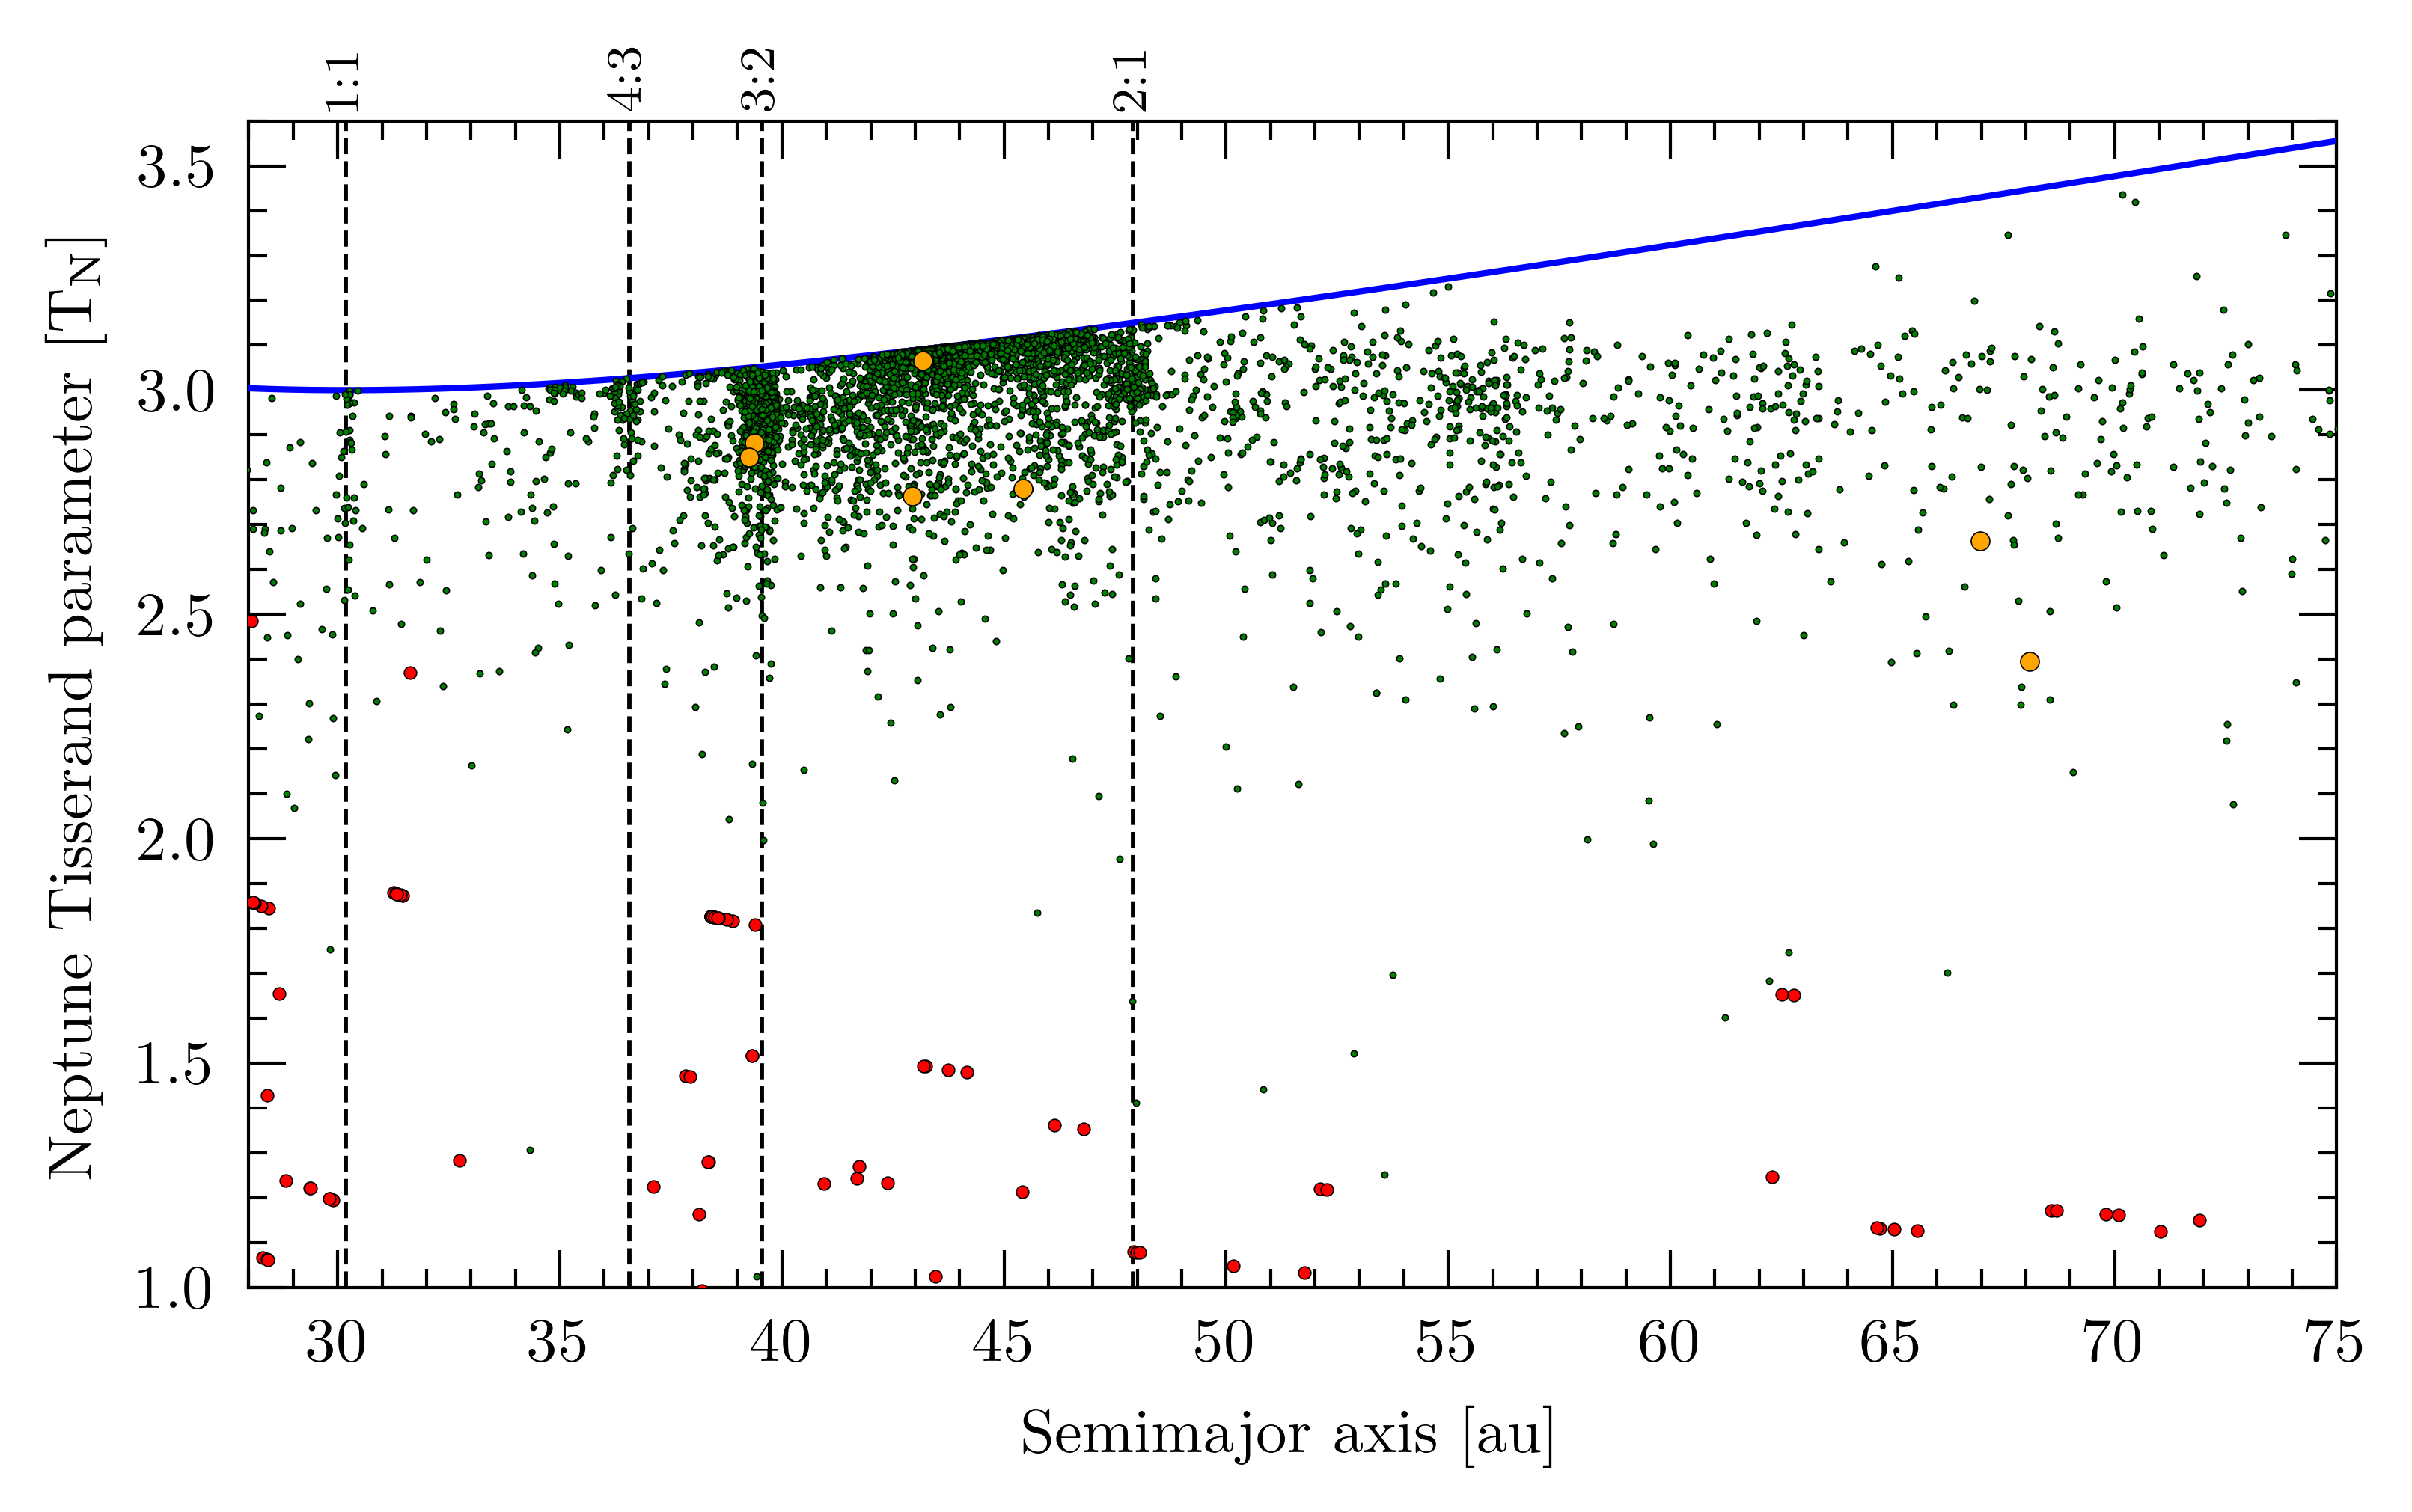

In [15]:
fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

minTN = 1.0 # Neptune Tisserand parameter
maxTN = 3.6

ax.set_xlim(aMin,aMax)
ax.xaxis.set_major_locator(MultipleLocator(5.0))
ax.xaxis.set_minor_locator(MultipleLocator(1.0))
ax.set_xlabel(r'Semimajor axis [au]',fontsize=axisFontSize)

ax.set_ylim(minTN,maxTN)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylabel(r'Neptune Tisserand parameter [T$_{\rm N}$]',fontsize=axisFontSize)

ax.plot(aOuter,TN,'o',ms=1,mfc='green',mec='black',mew=0.2,zorder=10)

ax.plot(aComet,TNc,'o',ms=2,mfc='red',mec='black',mew=0.2,zorder=10)

ax.plot(aTN,TNmax,'-',color='blue',lw=1,zorder=8)

# location of the dwarf planets

for dp in dwarfs:
    ax.plot(aDwarfs[dp],dpTN[dp],'o',mfc='orange',mec='black',ms=3,mew=0.2,zorder=10)
    
# Neptune mean-motion resonances

# first-order resonances 4:3, 3:2, 2:1

aN43 = a_pq(aNep,4,3)
aN32 = a_pq(aNep,3,2)
aN21 = a_pq(aNep,2,1)

ax.vlines([aN43,aN32,aN21,aNep],minTN,maxTN,ls=['--'],colors=['black'],lw=0.7,zorder=5)
ax.text(aN43,maxTN+0.02,'4:3',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(aN32,maxTN+0.02,'3:2',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(aN21,maxTN+0.02,'2:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(aNep,maxTN+0.02,'1:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()